# Data explorations
Starting point: mostly cleansed dataset. It contains NextXxxx columns that indicate the values for Fat, Protein and Production two weeks from the present.
Plan: verify data quality, merge with CRM data, then try some regressions for forecasting & feature importance. Forecasting target: NextValue = calculated value 2 weeks from present.


In [1]:
import pandas as pd
from sklearn import cluster
from sklearn import preprocessing
from matplotlib import pyplot as plt
from processLRDR import transformNegatives
import confidential as cf  #Value calculating formulas, not shared
import numpy as np

In [2]:

def loadCleansedData(test=False):
    if test:
        nrows = 10000
    else:
        nrows = None # Load all        
    df = pd.read_csv("..\\V_RobotPlusOneCows-LROnly-Comma-MainValuesModel\\V_RobotPlusOneCows-LROnly-Comma-MainValuesModel.csv",sep=";",decimal=",", low_memory=False, nrows=nrows, encoding='latin1')            
    df.loc[:,"Date"] = pd.to_datetime(arg=df.loc[:,"Date"],format="%Y%m%d") 
    df = df.iloc[:,3:] #dropping the artificial keys
    df.sort_values(by="Date",inplace=True)    
# harmonise percent values to < 1, so 3.3 => 0.033. Remove outliers. Values > 0.08 (8%) must be errors.
    for col in ["ProteinPercent", "FatPercent", "NextProtein", "NextFat"]:
        df.loc[:,col] = df.loc[:,col].apply( lambda x: x if x < 1 else x/100)
        df.loc[:,col] = df.loc[:,col].apply( lambda x: x if x < 0.08 else None)
        # replace outliers with mean
        mu = df.loc[:,col].mean()
        rowsWithNone = df.loc[:,col].isnull()
        df.loc[rowsWithNone,col] = mu
        
    df = df.rename({"Lypsyjä Last 24 h":"MilkingsLast24h",
                    "Syönti yhteensä":"FeedTotal24h"
                    }, axis="columns")      
    return df

def printCleansedFacts(df):
    print("Are these values OK, for example:")
    totalObs = df.shape[0]
    print("Total number of observations", totalObs)
    calv = sum(df["Calving No"]>8)
    print("Number of observations with more than 8 calvings: ", calv, " or ", round(calv/totalObs*100, 1), "% of the observations" )
    dim = sum(df.DIM>500)
    print("Number of observations with DIM > 500: ", dim, "or", round(dim/totalObs*100, 1), "% of the observations")
    print("Highest protein percentage: ", round(df.ProteinPercent.max()*100, 1), "%")
    print("Number of observations with protein > 5%: ", sum(df["ProteinPercent"]>0.05))
    
df = loadCleansedData()
printCleansedFacts(df)

Are these values OK, for example:
Total number of observations 169385
Number of observations with more than 8 calvings:  321  or  0.2 % of the observations
Number of observations with DIM > 500:  845 or 0.5 % of the observations
Highest protein percentage:  7.4 %
Number of observations with protein > 5%:  755


## Merge CRM data
Merge with CRM data to get some farm attributes, such as Organic (yes/no)

In [3]:
def loadCrmData(test=False):
    if test:
        nrows = 10000
    else:
        nrows = None # Load all        
    df = pd.read_csv("..\\SAPAnalyticsReport.csv",sep=";",decimal=",", low_memory=False, nrows=nrows, encoding='latin1')            
#    df = df.loc[((df.loc[:,"Pääasiakkuus"]=="Nauta") | (df.loc[:,"Pääasiakkuus"]=="Not assigned")) ,:]
    query = "(Pääasiakkuus == 'Nauta' | Pääasiakkuus == 'Not assigned') & (Industry == 'Alkutuottaja' | Industry == 'Not assigned' )"
    df = df.query(query)
    df.replace(to_replace="Not assigned", value="",inplace=True)
    width = df.shape[1]    
    for col in range((width - 11),width):    
        # format numeric columns
        df.iloc[:,col] = df.iloc[:,col].apply( lambda x: str(x).replace(".",""))
        df.iloc[:,col] = df.iloc[:,col].apply( lambda x: str(x).replace(",","."))
        df.iloc[:,col] = pd.to_numeric(df.iloc[:,col], errors="coerce")

    for col in ["Emolehmätila", "Kioski", "Koneruokinta", "Kuivaruokinta", "Lihakarjatila", "Loppukasvattamotila",
                "Luomukarjatila","Lypsykarjatila", "Parsi", "Pihatto", "Premix-ruokinta", "Puolitiiviste", "Robotti",
                "Täysrehu", "Tiiviste", "Edelläkävijä"]:    
        # format Boolean values as binary
        df.loc[:,col] = df.loc[:,col].apply( lambda x: 1 if x == "YES" else 0)
        df.loc[:,col] = df.loc[:,col].astype("int64")

        
    df.loc[:,"External ID"] = df.loc[:,"External ID"].apply( lambda x: str(x).replace("#","")) # fix some wrong values
#    df.loc[:,"External ID"] = df.loc[:,"External ID"].apply( lambda x: int(x))
    df.loc[:,"External ID"] = pd.to_numeric(df.loc[:,"External ID"], errors="coerce")
    df.loc[:,"Account ID"] = pd.to_numeric(df.loc[:,"Account ID"], errors="coerce").astype("int64", errors="ignore")
    df = df.loc[:,["External ID","Account","Pääasiakkuus","Päätilatyyppi", "Industry", "Kioski", "Koneruokinta","Lihakarjatila", "Luomukarjatila", "Lypsykarjatila", 
                   "Parsi", "Pihatto", "Robotti", "Täysrehu", "Tiiviste", "Edelläkävijä", "Lehmien määrä", "Keskituotos (litraa)"]]    
    df = df.rename({"External ID":"Farm",
                    "Pääasiakkuus":"CustomerType",
                    "Päätilatyyppi":"FarmType",
                    "Kioski":"Kiosk",
                    "Koneruokinta":"AutomaticFeed",
                    "Lihakarjatila":"MeatProducer",
                    "Luomukarjatila":"OrganicFarm",
                    "Lypsykarjatila":"DairyFarm",
                    "Parsi":"Yoke",
                    "Pihatto":"FreeRangeFarm",
                    "Robotti":"Robot",
                    "Täysrehu":"FullFeed",
                    "Tiiviste":"ConcentratedFeed",
                    "Edelläkävijä":"Pioneer",
                    "Lehmien määrä":"NbOfCows",
                    "Keskituotos (litraa)":"AvgProductionLiters",
                    }, axis="columns")        

    return df

def mergeCrmData(df, crmDf):    
    df = df.merge(right=crmDf, how="left", on="Farm")
    i = df.loc[:,"OrganicFarm"].isnull()
    df = df[~i]
    width = df.shape[1]
    for col in range(width-13,width-1):
    # reformat from float to int (0 and 1)
        df.iloc[:,col] = df.iloc[:,col].astype("int64")
#    df.to_csv("RoboCrmMerge.csv",sep=";",decimal=",")
    return df

crmDf = loadCrmData()
df = mergeCrmData(df, crmDf)
del(crmDf)
df.dtypes

C:\Users\pihlaart1\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\pihlaart1\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Date                   datetime64[ns]
Week                            int64
Month                           int64
Farm                            int64
CowCalvingKEY                  object
Cow Code                        int64
Cow Name                       object
Calving No                      int64
DIM                             int64
MilkingsLast24h               float64
FeedTotal24h                  float64
Production avg                float64
Production today              float64
FatPercent                    float64
ProteinPercent                float64
NextDIM                         int64
NextLyps                      float64
NextSyo                       float64
NextProdAvg                   float64
NextProdToday                 float64
NextFat                       float64
NextProtein                   float64
Account                        object
CustomerType                   object
FarmType                       object
Industry                       object
Kiosk       

## Feature engineering
Calculate NextValue that combines the target values NextProtein, NextFat, NextProduction
Encode the cyclical months so that for example month 1 is close to month 12

In [8]:
def encodeCyclicalValues(cyclicalSeries, numberOfPeriods):
        sin_feat = np.sin(cyclicalSeries/numberOfPeriods *2 *np.pi)
        cos_feat = np.cos(cyclicalSeries/numberOfPeriods *2 *np.pi)
        return sin_feat, cos_feat

# value calculation formulas removed and hidden

def addFeatures(df):
    df["ValueToday"] = calculateValueGeneric(df["Production today"], df["FatPercent"], df["ProteinPercent"])
    df["NextValue"] = calculateValueGeneric(df.NextProdToday, df.NextFat, df.NextProtein)
    df["MonthSin"], df["MonthCos"] = encodeCyclicalValues(df.Month, 12)
    return df

df = addFeatures(df)
df.dtypes

Date                   datetime64[ns]
Week                            int64
Month                           int64
Farm                            int64
CowCalvingKEY                  object
Cow Code                        int64
Cow Name                       object
Calving No                      int64
DIM                             int64
MilkingsLast24h               float64
FeedTotal24h                  float64
Production avg                float64
Production today              float64
FatPercent                    float64
ProteinPercent                float64
NextDIM                         int64
NextLyps                      float64
NextSyo                       float64
NextProdAvg                   float64
NextProdToday                 float64
NextFat                       float64
NextProtein                   float64
Account                        object
CustomerType                   object
FarmType                       object
Industry                       object
Kiosk       

# Predictions
Plan:
1) establish a baseline prediction
2) try different regressions and compare to baseline

In [10]:
def baselinePrediction(df):
    # baseline: guess the value just stays the same. Calculate it's error.
    baselineME = round(np.mean(abs(df.NextValue - df.ValueToday)), 2)
    print("Baseline mean error: ", baselineME)
baselinePrediction(df)

Baseline mean error:  1.4


Functions for splitting to train and test sets

In [15]:
def splitTrainTest(features, labels):
    from sklearn.model_selection import train_test_split
    trainFeatures, testFeatures, trainLabels, testLabels = train_test_split(features, labels, test_size=0.2)
    return trainFeatures, testFeatures, trainLabels, testLabels 

def dataframeToTrainTestData(df):
    y = np.array(df.loc[:, "NextValue"])
    X = df.drop("NextValue", axis="columns")
    trainX, testX, trainy, testy = splitTrainTest(X, y)    
    return trainX, testX, trainy, testy 

## Random forest
Try random forest 
First some helper functions

In [21]:
def evaluateResults(prediction, testy):
    errors = abs(prediction - testy)
    predictionME = round(np.mean(errors), 5)
    print("Prediction mean error: ", predictionME)  

def normalizeFeatures(df):
    d_scaled = preprocessing.scale(df) #Normal distribution
    df.loc[:,:] = d_scaled
    return df    

Then run the random forest with 50 trees for a reasonable runtime

In [22]:
features = ["Farm", "MonthSin", "MonthCos", "Calving No", "DIM", "MilkingsLast24h", "FeedTotal24h", 
                "Production avg", "FatPercent", "ProteinPercent", 
                "OrganicFarm", "Yoke", "FreeRangeFarm", "Robot", "NextValue"]
dfForPrediction = df.loc[:,features]
trainX, testX, trainy, testy = dataframeToTrainTestData(dfForPrediction)
print("Data import and formatting complete. Now training Random Forest model.")
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=50)
rf.fit(trainX, trainy)
prediction = rf.predict(testX)
evaluateResults(prediction, testy)
baselinePrediction(df)
# Get numerical feature importances (source: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0)
print("Feature importances:")
importances = list(rf.feature_importances_) 
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(features, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];



Data import and formatting complete. Now training Random Forest model.
Prediction mean error:  1.15885
Baseline mean error:  1.4
Feature importances:
Variable: Production avg       Importance: 0.72
Variable: DIM                  Importance: 0.12
Variable: FeedTotal24h         Importance: 0.03
Variable: FatPercent           Importance: 0.03
Variable: ProteinPercent       Importance: 0.03
Variable: Farm                 Importance: 0.02
Variable: Calving No           Importance: 0.02
Variable: MilkingsLast24h      Importance: 0.02
Variable: MonthSin             Importance: 0.01
Variable: MonthCos             Importance: 0.01
Variable: OrganicFarm          Importance: 0.0
Variable: Yoke                 Importance: 0.0
Variable: FreeRangeFarm        Importance: 0.0
Variable: Robot                Importance: 0.0


The random forest doesn't add much value to the baseline.
From the results, we see that clearly the strongest predictor for NextValue is the current production. So the production (and value) in 2 weeks are roughly the same as at present. Not that surprising.

## Linear regression
Let's try linear regression and some modifications. This time, instead of Production today, I'll include ValueToday into the features.

In [25]:
from sklearn import linear_model
features = ["Farm", "MonthSin", "MonthCos", "Calving No", "DIM", "MilkingsLast24h", "FeedTotal24h", 
                "ValueToday", "OrganicFarm", "NextValue"]
predDf = df.loc[:,features]
predDf = normalizeFeatures(predDf)
y = predDf.NextValue
X = predDf.drop("NextValue", axis="columns")
trainX, testX, trainy, testy = splitTrainTest(X, y)    
lin = linear_model.LinearRegression()
lin.fit(trainX, trainy)
prediction = lin.predict(testX)
evaluateResults(prediction, testy)
print("R2 of linear model: ", lin.score(testX, testy))
baselinePrediction(df)

Prediction mean error:  0.34725
R2 of linear model:  0.7416101634729334
Baseline mean error:  1.4


Interestingly, the linear model works much better than the random forest. Or perhaps it's due to the fact that we have ValueToday as feature?

Next, try adding the square of DIM as factor (to approximate the bell shape of the DIM curve)

In [27]:
X["DIM2"] = X["DIM"]*X["DIM"]    
X = normalizeFeatures(X)
trainX, testX, trainy, testy = splitTrainTest(X, y)
lin2 = linear_model.LinearRegression()
lin2.fit(trainX, trainy)
prediction = lin2.predict(testX)
evaluateResults(prediction, testy)   
print("R2 of DIM2 model: ", lin2.score(testX, testy))
print("Model coefficients: ")
features[len(lin2.coef_)-1] ="DIM2"
for i in range(0,len(lin2.coef_)):
    print(features[i], lin2.coef_[i])


Prediction mean error:  0.33602
R2 of DIM2 model:  0.7646308838604667
Model coefficients: 
Farm 0.004831385612679194
MonthSin 0.02277841651120112
MonthCos 0.00028046921607825884
Calving No 0.017199578769987484
DIM -0.2955474271847922
MilkingsLast24h 0.004030052261540353
FeedTotal24h -0.006893353847811001
ValueToday 0.744999916799489
OrganicFarm -0.014475498021592825
DIM2 0.1245137115391754


Adding the DIM^2 term didn't improve performance much. 

Now try to decide the feature importance in a linear model (ref: http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_regression.html)


F-regression scores:
Feature   F-value     p-value
Farm 115.21640681480264 7.198523156091714e-27
MonthSin 782.0080373466053 1.0883393087220832e-171
MonthCos 1.30176067224289 0.25389348446055165
Calving No 6915.945458405101 0.0
DIM 61622.048982063156 0.0
MilkingsLast24h 56657.19629112638 0.0
FeedTotal24h 23530.128915474874 0.0
ValueToday 386949.1173061198 0.0
OrganicFarm 352.95176757849345 1.1608400721916165e-78
DIM2 5007.425964980078 0.0


<Container object of 10 artists>

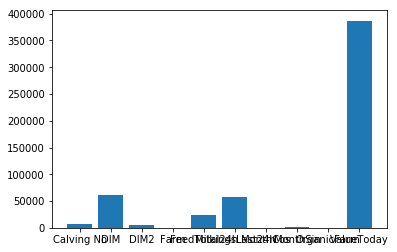

In [33]:
from sklearn.feature_selection import f_regression
fr = f_regression(X, y)
print()
print("F-regression scores:")
print("Feature   F-value     p-value")
for i in range(0,len(features)):
    print(features[i], fr[0][i], fr[1][i])

plt.bar(features, fr[0], label="Feature F-values")

ValueToday is decisive

## Linear regression for current value
Now let's leave the 2 week forecast aside and try to predict the value today (function of milk quantity, fat and protein) based on some selected factors. So repeat the code from above with target ValueToday.

In [34]:
    features = ["Farm", "MonthSin", "MonthCos", "Calving No", "DIM", "MilkingsLast24h", "FeedTotal24h",
                "OrganicFarm", "ValueToday"]    
    predDf = df.loc[:,features]
    predDf = normalizeFeatures(predDf)
    y = predDf.ValueToday
    X = predDf.drop("ValueToday", axis="columns")
    trainX, testX, trainy, testy = splitTrainTest(X, y)    
    lin = linear_model.LinearRegression()
    lin.fit(trainX, trainy)
    prediction = lin.predict(testX)
    evaluateResults(prediction, testy)
    print ("Let's try adding the square of DIM")
    X["DIM2"] = X["DIM"]*X["DIM"]    
    X = normalizeFeatures(X)
    trainX, testX, trainy, testy = splitTrainTest(X, y)
    lin2 = linear_model.LinearRegression()
    lin2.fit(trainX, trainy)
    prediction = lin2.predict(testX)
    evaluateResults(prediction, testy)   
    print("R2 of DIM2 model: ", lin2.score(testX, testy))
    print("Model coefficients: ")
    features[len(lin2.coef_)-1] ="DIM2"
    for i in range(0,len(lin2.coef_)):
        print(features[i], lin2.coef_[i])

Prediction mean error:  0.53839
Let's try adding the square of DIM
Prediction mean error:  0.54354
R2 of DIM2 model:  0.5017519071223342
Model coefficients: 
Farm 0.0683394154507861
MonthSin 0.040467574530307235
MonthCos -0.019362155342759136
Calving No 0.19538466003250166
DIM -0.21110043614723495
MilkingsLast24h 0.46995146983157426
FeedTotal24h 0.20725235919916124
OrganicFarm -0.0306651308053307
DIM2 -0.027265777082865407


A pretty bad forecast, considering that the mean error is based on normalised values. Also the R2 is bad.

Baseline for forecasting ValueToday: just use the mean of all values. Let's calculate it and it's performance.

In [45]:
bl = df.ValueToday.mean()
predDf["bl"]=bl
predDf = normalizeFeatures(predDf.iloc[:,1:])
evaluateResults(predDf.bl,testy)

C:\Users\pihlaart1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:181: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
C:\Users\pihlaart1\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Prediction mean error:  0.79855


C:\Users\pihlaart1\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(The warnings can be ignored. They are due to the fact that all values of bl are identical.)
OK, at least we do better than the baseline.

## Generalized Linear Model
Try a GLM with Gamma distribution. The default link function is inverse power. Let's try identity and power.
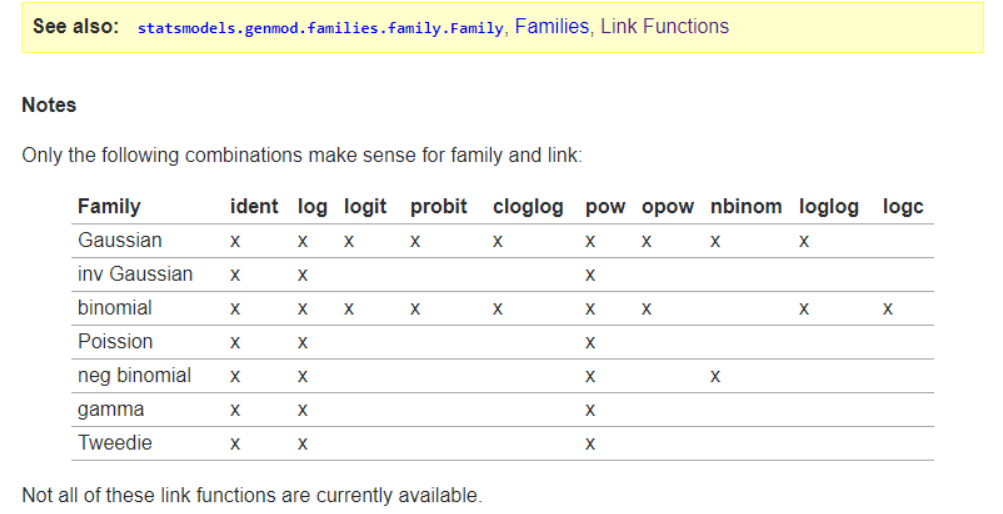


In [46]:
# source: http://www.statsmodels.org/devel/generated/statsmodels.genmod.generalized_linear_model.GLM.html?highlight=glm
# creds: https://stackoverflow.com/questions/41749167/glm-gamma-regression-in-python-statsmodels        
import statsmodels.api as sm 
model = sm.GLM(trainy, trainX, family=sm.families.Gamma(link=sm.genmod.families.links.identity)).fit()
print(model.summary())
prediction = model.predict(testX)
evaluateResults(prediction, testy)

C:\Users\pihlaart1\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
C:\Users\pihlaart1\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:244: DomainWarning: The identity link function does not respect the domain of the Gamma family.
  DomainWarning)


                 Generalized Linear Model Regression Results                  
Dep. Variable:             ValueToday   No. Observations:               135133
Model:                            GLM   Df Residuals:                   135124
Model Family:                   Gamma   Df Model:                            8
Link Function:               identity   Scale:               58631.69271301637
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Mon, 28 May 2018   Deviance:                   3.3476e+06
Time:                        23:35:35   Pearson chi2:                 7.92e+09
No. Iterations:                   100                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Farm               -0.3837      0.087     -4.435      0.000      -0.553      -0.214
MonthSin           -0.0092      0.001

C:\Users\pihlaart1\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:738: RuntimeWarning: invalid value encountered in log
  np.log(endog) + np.log(scale) + scale *


A prediction mean error of 1.32, if reliable, is horribly bad performance.
Try power function.

In [47]:
model = sm.GLM(trainy, trainX, family=sm.families.Gamma(link=sm.genmod.families.links.Power)).fit()
print(model.summary())
prediction = model.predict(testX)
evaluateResults(prediction, testy)

ValueError: Invalid link for family, should be in [<class 'statsmodels.genmod.families.links.log'>, <class 'statsmodels.genmod.families.links.identity'>, <class 'statsmodels.genmod.families.links.inverse_power'>]. (got <statsmodels.genmod.families.links.Power object at 0x000000C2013B0D68>)

So power doesn't work after all? How about inverse power?

In [48]:
model = sm.GLM(trainy, trainX, family=sm.families.Gamma(link=sm.genmod.families.links.inverse_power)).fit()
print(model.summary())
prediction = model.predict(testX)
evaluateResults(prediction, testy)

C:\Users\pihlaart1\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:244: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  DomainWarning)


                 Generalized Linear Model Regression Results                  
Dep. Variable:             ValueToday   No. Observations:               135133
Model:                            GLM   Df Residuals:                   135124
Model Family:                   Gamma   Df Model:                            8
Link Function:          inverse_power   Scale:               122.4439165846426
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Mon, 28 May 2018   Deviance:                   4.4661e+06
Time:                        23:44:10   Pearson chi2:                 1.65e+07
No. Iterations:                    64                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Farm               -8.3517      0.251    -33.220      0.000      -8.844      -7.859
MonthSin           -0.2693      0.008

C:\Users\pihlaart1\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:738: RuntimeWarning: invalid value encountered in log
  np.log(endog) + np.log(scale) + scale *


I quit.